In [24]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import nnls


import xarray as xr
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d
import glob

In [2]:
wind_path = '/data/users/kgruber/Data/era5/BRA/eff_ws'
dpath = '/data/users/kgruber/other-data/BRA'
base_path = '/data/users/kgruber/other-data/BRA_turbine_locations'
results_path = '/data/users/kgruber/results/BRA_turbine_locations'

In [8]:
wind = xr.open_mfdataset(wind_path + '/era5_wind_BRA_*.nc',chunks={'time':30})

In [4]:
wp_twp = pd.read_csv(dpath + '/windparks_TWP.csv',header=0,index_col = 0)

In [5]:
states_NE = ['Paraíba','Rio Grande do Norte','Bahia','Ceará','Sergipe','Pernambuco','Piaui','Maranhão']

In [6]:
lons = wp_twp.long[[s in states_NE for s in wp_twp.state.values]]
lats = wp_twp.lat[[s in states_NE for s in wp_twp.state.values]]
wpyears = wp_twp.year[[s in states_NE for s in wp_twp.state.values]]
wpcap = wp_twp.cap[[s in states_NE for s in wp_twp.state.values]]

In [9]:
wind_NE = wind.sel(latitude=slice(-1,-17),longitude=slice(-45,-34))

In [10]:
gen_NE_csv = pd.read_csv(base_path + '/hourly_generation_NE.csv',
                         sep=';',index_col=0,usecols=[0,7],
                         parse_dates=True,dayfirst=True).rename(columns={'Selecione Tipo de GE Simp 4':'gen'})[1:]
# remove duplicate time stamps
gen_NE_csv = gen_NE_csv.loc[~gen_NE_csv.index.duplicated(keep='first')]


# data are not in right order and some lines are missing... therefore sort and interpolate missing values
#gen_NE_csvs = gen_NE_csv.sort_index()
# insert in full time series and fill in missing data
dr = pd.date_range(start=gen_NE_csv.index.min(),end=gen_NE_csv.index.max(),freq='H')
gen_NE = pd.DataFrame({'gen':dr.map(gen_NE_csv.gen)},index=dr).interpolate()
gen_NExr = gen_NE.to_xarray().rename({'index':'time'})

In [12]:
ll = np.array(np.meshgrid(wind_NE.latitude, wind_NE.longitude)).reshape(2, len(wind_NE.latitude)*len(wind_NE.longitude))

In [13]:
wi = wind_NE.interp(coords={'latitude':xr.DataArray(ll[0],dims='loc'),
                       'longitude':xr.DataArray(ll[1],dims='loc')},method='nearest').drop(['longitude','latitude'])

### Analyse matrix rank

without specifing tolerance, ranks are quite low and DECREASE with longer time spans

In [14]:
np.linalg.matrix_rank(wi.wh100.sel(time='2018'))

613

In [15]:
np.linalg.matrix_rank(wi.wh100.where(~np.isnan(wi.wh100),np.pi).transpose('time','loc').sel(time=slice('2014','2018')))

132

In [16]:
np.linalg.matrix_rank(wi.wh100.where(~np.isnan(wi.wh100),np.pi).transpose('time','loc').sel(time=slice('2008','2018')))

46

if we specify tolerance ranks are the size of the matrix

In [17]:
np.linalg.matrix_rank(wi.wh100.where(~np.isnan(wi.wh100),np.pi).transpose('time','loc').sel(time=slice('2017','2018')),tol=10**-3)

2405

In [18]:
np.linalg.matrix_rank(wi.wh100.where(~np.isnan(wi.wh100),np.pi).transpose('time','loc').sel(time=slice('2014','2018')),tol=10**-3)

2405

In [19]:
np.linalg.matrix_rank(wi.wh100.where(~np.isnan(wi.wh100),np.pi).transpose('time','loc').sel(time=slice('2009','2018')),tol=10**-3)

2405

there are NANs in the merra data!!!

In [20]:
np.where(np.isnan(wi.wh100.transpose('time','loc').sel(time=slice('2014','2018'))))

(array([ 1926,  2827,  3136,  3143,  5223,  5231,  5521,  5679,  5679,
         6643,  6746,  6814,  6838,  6874,  6894,  6931,  7263,  9095,
         9291, 12006, 13423, 13439, 13441, 13781, 13797, 13894, 14515,
        14544, 14588, 15191, 20350, 20352, 20422, 21538, 21696, 21772,
        21799, 23039, 24339, 24467, 29675, 29750, 29760, 30733, 30751,
        30767, 31005, 31038, 31172, 31189, 31209, 31209, 31223, 31296,
        31344, 31346, 33682, 33718, 33722, 33814]),
 array([1237, 1942, 1878, 2401,  717, 2095, 2092,  130,  718, 2159, 1437,
        1895, 1108,  980, 1434, 1438, 1237, 2091, 2027, 1749, 1304, 2157,
        1241, 1176, 1172, 1111, 1306, 1109, 2092, 2028, 1175, 1046, 2221,
        2196,  653, 1962, 1235, 2028, 1832, 1238, 1436, 2398, 2136, 1009,
        2075, 2339, 1238, 2125, 1043,  915, 2208, 2269, 1170, 2403, 1635,
        1944,  329, 2158, 2030, 1045]))

In [21]:
t1 = datetime.datetime.now()
res_tol = np.linalg.lstsq(wi.wh100.transpose('time','loc').sel(time='2018'),gen_NExr.gen.sel(time='2018'),rcond=10**-3)
t2 = datetime.datetime.now()
print(t2-t1)

0:00:03.284767


In [22]:
cc_res_tol = xr.DataArray(res_tol[0].reshape(len(wind_NE.latitude),len(wind_NE.longitude)),
                          dims=['lat','lon'],
                          coords={'lat':wind_NE.latitude.values,'lon':wind_NE.longitude.values})

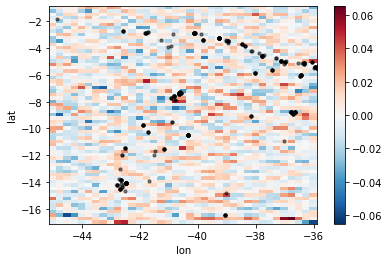

In [23]:
year=2018
cc_res_tol.transpose('lat','lon').plot()
plt.scatter(lons[wpyears<=2018],lats[wpyears<=year],color='black',s=10,alpha=0.5)

try nonnegative regression

In [26]:
res_nnls = nnls(wi.wh100.transpose('time','loc').sel(time='2018'),gen_NExr.gen.sel(time='2018'))

In [27]:
cc_res_nnls = xr.DataArray(res_nnls[0].reshape(len(wind_NE.latitude),len(wind_NE.longitude)),
                          dims=['lat','lon'],
                          coords={'lat':wind_NE.latitude.values,'lon':wind_NE.longitude.values})

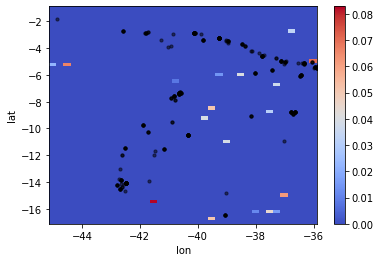

In [29]:
year=2018
cc_res_nnls.transpose('lat','lon').plot(cmap='coolwarm')
plt.scatter(lons[wpyears<=2018],lats[wpyears<=year],color='black',s=10,alpha=0.5)